In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid

train_path = '/kaggle/input/nli-training-data/training_data/NLI/train.csv'
dev_path   = '/kaggle/input/nli-training-data/training_data/NLI/dev.csv'

train_df = pd.read_csv(train_path)
dev_df   = pd.read_csv(dev_path)


In [3]:

train_texts = train_df['premise'] + " [SEP] " + train_df['hypothesis']
dev_texts = dev_df['premise'] + " [SEP] " + dev_df['hypothesis']

y_train = train_df['label'].values
y_dev = dev_df['label'].values


In [4]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Conv1D, Bidirectional, LSTM, Dense, 
                                     Dropout, Layer, BatchNormalization)
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2

# 1. Data Loading and Preprocessing

train_path = '/kaggle/input/nli-training-data/training_data/NLI/train.csv'
dev_path   = '/kaggle/input/nli-training-data/training_data/NLI/dev.csv'

train_df = pd.read_csv(train_path)
dev_df   = pd.read_csv(dev_path)

train_texts_raw = train_df['premise'] + ' [SEP] ' + train_df['hypothesis']
dev_texts_raw   = dev_df['premise']   + ' [SEP] ' + dev_df['hypothesis']

y_train = train_df['label'].values
y_dev   = dev_df['label'].values

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


train_texts = [clean_text(t) for t in train_texts_raw]
dev_texts   = [clean_text(t) for t in dev_texts_raw]


MAX_NUM_WORDS = 5000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_texts)

X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_dev_seq   = tokenizer.texts_to_sequences(dev_texts)

MAX_LEN = 70
X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_dev   = pad_sequences(X_dev_seq,   maxlen=MAX_LEN, padding='post', truncating='post')

y_train = np.array(y_train)
y_dev   = np.array(y_dev)


# 3. Attention Layer
class Attention(Layer):

    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        score = tf.matmul(inputs, self.W)  # (batch_size, time_steps, 1)
        score = tf.nn.softmax(score, axis=1)
        context_vector = inputs * score
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_dim)
        return context_vector


# 4. CNN + BiLSTM + Attention

def build_cnn_bilstm_attention_model(embedding_dim, lstm_units, dropout_rate):
tention -> Dense(64) -> Dropout -> Dense(3)
    conv_filters = 64
    kernel_size  = 3
    
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=embedding_dim, input_length=MAX_LEN))
    
    # CNN Layer
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # BiLSTM Layer1
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    
    # BiLSTM Layer2
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    
    # Attention
    model.add(Attention())
    
    # Dense
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    
    return model

# 5. Training and evaluation function

def train_and_evaluate(embedding_dim, lstm_units, dropout_rate):
    print(f"\n📦 Training with: emb_dim={embedding_dim}, lstm_units={lstm_units}, dropout={dropout_rate}")
    
    model = build_cnn_bilstm_attention_model(embedding_dim, lstm_units, dropout_rate)
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=5e-4),
        metrics=['accuracy']
    )
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            verbose=1
        )
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_dev, y_dev),
        epochs=4,
        batch_size=32,
        callbacks=callbacks,
        verbose=2
    )
    
    y_dev_pred = model.predict(X_dev).argmax(axis=1)
    acc = accuracy_score(y_dev, y_dev_pred)
    f1  = f1_score(y_dev, y_dev_pred, average='weighted')
    
    print(f"Dev Accuracy: {acc:.4f}, Dev F1: {f1:.4f}")
    print("\n Classification Report:")
    print(classification_report(y_dev, y_dev_pred, digits=4))
    
    return acc, f1,model,history

# 6. Hyperparameter grid search
param_grid = {
    'embedding_dim': [100, 150, 200],
    'lstm_units': [64, 128],
    'dropout_rate': [0.3, 0.5]
}

best_f1 = 0
best_acc = 0
best_params = None
best_model = 0
best_history = None

for params in ParameterGrid(param_grid):
    acc, f1,model,history = train_and_evaluate(
        embedding_dim=params['embedding_dim'],
        lstm_units=params['lstm_units'],
        dropout_rate=params['dropout_rate']
    )
    if f1 > best_f1:
        best_f1 = f1
        best_acc = acc
        best_params = params
        best_model = model
        best_history = history

print(" Best Accuracy:", best_acc)
print(" Best F1 Score:", best_f1)
print(" Best Parameters:", best_params)
best_model.save('bilstm_best_model.h5', save_format='h5')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

📦 Training with: emb_dim=100, lstm_units=64, dropout=0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/4
764/764 - 26s - 34ms/step - accuracy: 0.5304 - loss: 0.7427 - val_accuracy: 0.6370 - val_loss: 0.6731 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 16s - 21ms/step - accuracy: 0.6661 - loss: 0.6290 - val_accuracy: 0.6618 - val_loss: 0.6194 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 16s - 21ms/step - accuracy: 0.7308 - loss: 0.5529 - val_accuracy: 0.6547 - val_loss: 0.6513 - learning_rate: 5.0000e-04
Epoch 4/4

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
764/764 - 16s - 21ms/step - accuracy: 0.7879 - loss: 0.4704 - val_accuracy: 0.6538 - val_loss: 0.7070 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
✅ Dev Accuracy: 0.6618, Dev F1: 0.6608

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6638    0.6096    0.6355      3258
           1     0.6603    0.7108    0.6846      3478

    accuracy                         0.6618      6736
   macro avg     0.6620    0.6602    0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 23s - 31ms/step - accuracy: 0.5826 - loss: 0.7239 - val_accuracy: 0.6710 - val_loss: 0.6314 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 18s - 24ms/step - accuracy: 0.6991 - loss: 0.5928 - val_accuracy: 0.6759 - val_loss: 0.6147 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 18s - 24ms/step - accuracy: 0.7540 - loss: 0.5186 - val_accuracy: 0.6660 - val_loss: 0.6448 - learning_rate: 5.0000e-04
Epoch 4/4

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
764/764 - 18s - 24ms/step - accuracy: 0.8031 - loss: 0.4324 - val_accuracy: 0.6639 - val_loss: 0.7016 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
✅ Dev Accuracy: 0.6759, Dev F1: 0.6753

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6765    0.6323    0.6537      3258
           1     0.6754    0.7168    0.6955      3478

    accuracy                         0.6759      6736
   macro avg     0.6760    0.6745    0.6746     

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 21s - 28ms/step - accuracy: 0.5591 - loss: 0.7355 - val_accuracy: 0.6490 - val_loss: 0.6556 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 16s - 21ms/step - accuracy: 0.6964 - loss: 0.6071 - val_accuracy: 0.6658 - val_loss: 0.6215 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 16s - 21ms/step - accuracy: 0.7579 - loss: 0.5194 - val_accuracy: 0.6523 - val_loss: 0.6765 - learning_rate: 5.0000e-04
Epoch 4/4

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
764/764 - 16s - 21ms/step - accuracy: 0.8156 - loss: 0.4287 - val_accuracy: 0.6443 - val_loss: 0.7729 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
✅ Dev Accuracy: 0.6658, Dev F1: 0.6617

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6925    0.5559    0.6167      3258
           1     0.6489    0.7688    0.7038      3478

    accuracy                         0.6658      6736
   macro avg     0.6707    0.6623    0.6602      

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 23s - 30ms/step - accuracy: 0.5906 - loss: 0.7218 - val_accuracy: 0.6640 - val_loss: 0.6380 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 18s - 24ms/step - accuracy: 0.7036 - loss: 0.5936 - val_accuracy: 0.6632 - val_loss: 0.6244 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 18s - 24ms/step - accuracy: 0.7561 - loss: 0.5121 - val_accuracy: 0.6691 - val_loss: 0.6619 - learning_rate: 5.0000e-04
Epoch 4/4

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
764/764 - 18s - 24ms/step - accuracy: 0.8137 - loss: 0.4211 - val_accuracy: 0.6560 - val_loss: 0.7646 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
✅ Dev Accuracy: 0.6632, Dev F1: 0.6553

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.7103    0.5126    0.5955      3258
           1     0.6379    0.8042    0.7114      3478

    accuracy                         0.6632      6736
   macro avg     0.6741    0.6584    0.6535      

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 22s - 29ms/step - accuracy: 0.5605 - loss: 0.7358 - val_accuracy: 0.6605 - val_loss: 0.6416 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 16s - 21ms/step - accuracy: 0.7022 - loss: 0.6015 - val_accuracy: 0.6652 - val_loss: 0.6262 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 16s - 21ms/step - accuracy: 0.7636 - loss: 0.5159 - val_accuracy: 0.6663 - val_loss: 0.6446 - learning_rate: 5.0000e-04
Epoch 4/4

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
764/764 - 16s - 21ms/step - accuracy: 0.8190 - loss: 0.4204 - val_accuracy: 0.6557 - val_loss: 0.7303 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
✅ Dev Accuracy: 0.6652, Dev F1: 0.6650

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6580    0.6412    0.6495      3258
           1     0.6717    0.6878    0.6796      3478

    accuracy                         0.6652      6736
   macro avg     0.6648    0.6645    0.6646      

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 23s - 31ms/step - accuracy: 0.5993 - loss: 0.7225 - val_accuracy: 0.6679 - val_loss: 0.6266 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 18s - 24ms/step - accuracy: 0.7062 - loss: 0.5885 - val_accuracy: 0.6689 - val_loss: 0.6217 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 18s - 24ms/step - accuracy: 0.7704 - loss: 0.4988 - val_accuracy: 0.6593 - val_loss: 0.6703 - learning_rate: 5.0000e-04
Epoch 4/4

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
764/764 - 18s - 24ms/step - accuracy: 0.8288 - loss: 0.3921 - val_accuracy: 0.6523 - val_loss: 0.7341 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
✅ Dev Accuracy: 0.6689, Dev F1: 0.6616

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.7169    0.5215    0.6038      3258
           1     0.6429    0.8071    0.7157      3478

    accuracy                         0.6689      6736
   macro avg     0.6799    0.6643    0.6597      

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 22s - 28ms/step - accuracy: 0.5124 - loss: 0.7586 - val_accuracy: 0.6121 - val_loss: 0.6954 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 16s - 21ms/step - accuracy: 0.6455 - loss: 0.6553 - val_accuracy: 0.6649 - val_loss: 0.6285 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 16s - 21ms/step - accuracy: 0.7159 - loss: 0.5761 - val_accuracy: 0.6685 - val_loss: 0.6133 - learning_rate: 5.0000e-04
Epoch 4/4
764/764 - 16s - 21ms/step - accuracy: 0.7522 - loss: 0.5209 - val_accuracy: 0.6593 - val_loss: 0.6729 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
✅ Dev Accuracy: 0.6685, Dev F1: 0.6674

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6732    0.6114    0.6408      3258
           1     0.6648    0.7220    0.6922      3478

    accuracy                         0.6685      6736
   macro avg     0.6690    0.6667    0.6665      6736
weighted avg     0.6689    0.6685    0.6674      6736


📦 Training with:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 23s - 30ms/step - accuracy: 0.5693 - loss: 0.7454 - val_accuracy: 0.6510 - val_loss: 0.6563 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 18s - 24ms/step - accuracy: 0.6882 - loss: 0.6170 - val_accuracy: 0.6660 - val_loss: 0.6213 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 18s - 24ms/step - accuracy: 0.7344 - loss: 0.5576 - val_accuracy: 0.6640 - val_loss: 0.6488 - learning_rate: 5.0000e-04
Epoch 4/4

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
764/764 - 18s - 24ms/step - accuracy: 0.7705 - loss: 0.4992 - val_accuracy: 0.6480 - val_loss: 0.6741 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
✅ Dev Accuracy: 0.6660, Dev F1: 0.6660

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6546    0.6550    0.6548      3258
           1     0.6766    0.6763    0.6764      3478

    accuracy                         0.6660      6736
   macro avg     0.6656    0.6656    0.6656      

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 21s - 28ms/step - accuracy: 0.5061 - loss: 0.7646 - val_accuracy: 0.5163 - val_loss: 0.7215 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 16s - 21ms/step - accuracy: 0.6006 - loss: 0.6865 - val_accuracy: 0.6547 - val_loss: 0.6342 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 16s - 21ms/step - accuracy: 0.7059 - loss: 0.5963 - val_accuracy: 0.6612 - val_loss: 0.6345 - learning_rate: 5.0000e-04
Epoch 4/4

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
764/764 - 16s - 21ms/step - accuracy: 0.7496 - loss: 0.5356 - val_accuracy: 0.6621 - val_loss: 0.6444 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
✅ Dev Accuracy: 0.6547, Dev F1: 0.6453

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.7055    0.4911    0.5791      3258
           1     0.6289    0.8079    0.7073      3478

    accuracy                         0.6547      6736
   macro avg     0.6672    0.6495    0.6432      

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 24s - 32ms/step - accuracy: 0.5063 - loss: 0.7600 - val_accuracy: 0.5163 - val_loss: 0.7189 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 18s - 24ms/step - accuracy: 0.5080 - loss: 0.7102 - val_accuracy: 0.5163 - val_loss: 0.7018 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 18s - 24ms/step - accuracy: 0.5891 - loss: 0.6735 - val_accuracy: 0.6569 - val_loss: 0.6266 - learning_rate: 5.0000e-04
Epoch 4/4
764/764 - 18s - 24ms/step - accuracy: 0.6984 - loss: 0.5904 - val_accuracy: 0.6683 - val_loss: 0.6097 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
✅ Dev Accuracy: 0.6683, Dev F1: 0.6650

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6905    0.5697    0.6243      3258
           1     0.6537    0.7608    0.7032      3478

    accuracy                         0.6683      6736
   macro avg     0.6721    0.6652    0.6637      6736
weighted avg     0.6715    0.6683    0.6650      6736


📦 Training with:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 21s - 28ms/step - accuracy: 0.5030 - loss: 0.7640 - val_accuracy: 0.5163 - val_loss: 0.7220 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 16s - 21ms/step - accuracy: 0.5063 - loss: 0.7158 - val_accuracy: 0.5163 - val_loss: 0.7068 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 16s - 21ms/step - accuracy: 0.5842 - loss: 0.6803 - val_accuracy: 0.6646 - val_loss: 0.6298 - learning_rate: 5.0000e-04
Epoch 4/4
764/764 - 16s - 21ms/step - accuracy: 0.6910 - loss: 0.6034 - val_accuracy: 0.6645 - val_loss: 0.6230 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
✅ Dev Accuracy: 0.6645, Dev F1: 0.6532

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.7317    0.4837    0.5824      3258
           1     0.6329    0.8338    0.7196      3478

    accuracy                         0.6645      6736
   macro avg     0.6823    0.6588    0.6510      6736
weighted avg     0.6807    0.6645    0.6532      6736


📦 Training with:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


764/764 - 24s - 31ms/step - accuracy: 0.5391 - loss: 0.7548 - val_accuracy: 0.6516 - val_loss: 0.6601 - learning_rate: 5.0000e-04
Epoch 2/4
764/764 - 18s - 24ms/step - accuracy: 0.6797 - loss: 0.6280 - val_accuracy: 0.6667 - val_loss: 0.6214 - learning_rate: 5.0000e-04
Epoch 3/4
764/764 - 18s - 24ms/step - accuracy: 0.7271 - loss: 0.5629 - val_accuracy: 0.6605 - val_loss: 0.6354 - learning_rate: 5.0000e-04
Epoch 4/4

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
764/764 - 18s - 24ms/step - accuracy: 0.7690 - loss: 0.5013 - val_accuracy: 0.6544 - val_loss: 0.6875 - learning_rate: 5.0000e-04
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
✅ Dev Accuracy: 0.6667, Dev F1: 0.6647

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6787    0.5905    0.6315      3258
           1     0.6580    0.7381    0.6958      3478

    accuracy                         0.6667      6736
   macro avg     0.6683    0.6643    0.6637      

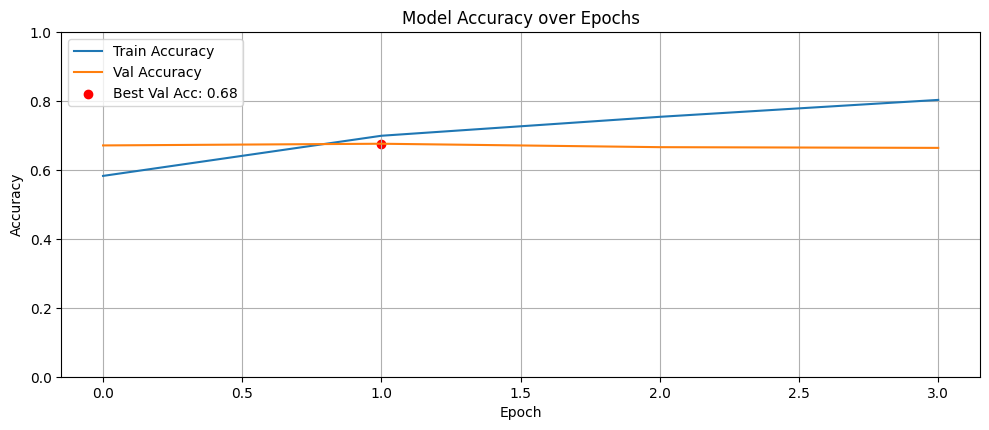

In [5]:
import matplotlib.pyplot as plt
import numpy as np

acc = best_history.history['accuracy']
val_acc = best_history.history['val_accuracy']
loss = best_history.history['loss']
val_loss = best_history.history['val_loss']
epochs = range(len(acc))

best_epoch = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch]

plt.figure(figsize=(10, 8))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.scatter(best_epoch, best_val_acc, color='red', label=f'Best Val Acc: {best_val_acc:.2f}')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.savefig('training_curves.png', dpi=300)
plt.show()
